In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Dropout1d(0.2),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        return self.model(x)

In [3]:
net = Discriminator()
in_vec = torch.randn(1, 3, 32, 32)
out_vec = net(in_vec)
out_vec.shape

torch.Size([1, 1])

In [4]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(64, 1024),
            nn.Unflatten(-1, (64, 4, 4)),

            nn.ConvTranspose2d(64, 64, (4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 128, (4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 256, (4, 4), stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 3, (5, 5), padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

    def generate_random_batch(self, size: int, device: str):
        random_vec = torch.normal(0, 1, (size, 64)).to(device)
        return self(random_vec)

In [5]:
gen = Generator()

rand_vec = torch.randn((4, 64))
rand_out = gen(rand_vec)
rand_out.shape

torch.Size([4, 3, 32, 32])

In [6]:
def choose_device():
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


device = choose_device()
device

'mps'

In [7]:
import torchvision
from torchvision.transforms import v2
from torchvision.io import read_image
import os

class ImageDataset(Dataset):

    def __init__(self, data_path: str, transforms: v2.Compose, device: str):
        super().__init__()

        self.device = device
        self.data_path = data_path
        self.transforms = transforms
        self.all = self._read_all_images()


    def __len__(self):
        return len(self.all)

    def __getitem__(self, idx):
        return self.all[idx]
    

    def _read_all_images(self):
        all = []
        for image in os.listdir(self.data_path):
            all.append(
                self.transforms(read_image(f"{self.data_path}/{image}")).to(self.device)
            )
        return all

In [8]:
transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((32, 32)),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

ds = ImageDataset("./data/crawled_cakes", transforms, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99848306..1.0000007].


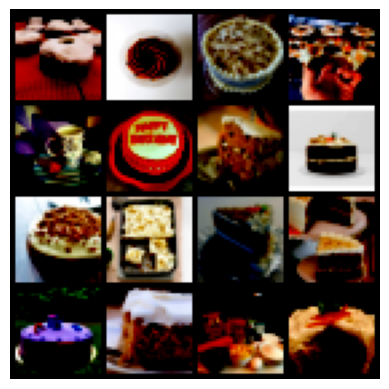

In [9]:
from itertools import islice

cakes = list(islice(ds, 16))
cakes_tensor = torch.stack(cakes)
grid = torchvision.utils.make_grid(cakes_tensor.to("cpu"), 4)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off');

In [10]:
# from torch.nn.functional import sigmoid

# class SimpleModel(nn.Module):

#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             nn.Linear(1, 10),
#             nn.ReLU(),
#             nn.Linear(10, 1),
#         )

#     def forward(self, x):
#         return self.model(x)
    
#     def predict_proba(self, x):
#         return sigmoid(self(x))

In [11]:
# from torch.optim import SGD

# false_vec = torch.randn((100, 1))
# true_vec = torch.zeros((100, 1)) + 0.5

# inputs = torch.concat((false_vec, true_vec))
# labels = torch.concat((torch.zeros(100, 1) + 0., torch.zeros(100, 1) + 1.))


# simple = SimpleModel()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = SGD(islice(simple.parameters(), 2))

In [12]:
# for i in range(1_000_000):
#     out = simple(inputs)
#     loss = criterion(out, labels)
#     loss.backward()

#     optimizer.step()
#     optimizer.zero_grad()

#     if i % 50_000 == 0:
#         print(loss.item())

In [35]:
from torch.optim import Adam

batch_size = 32
data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

discriminator = Discriminator().to(device)
generator = Generator().to(device)

dis_optim = Adam(discriminator.parameters(), lr=0.00001, weight_decay=0.0001)
gen_optim = Adam(generator.parameters(), lr=0.00001)
criterion = nn.BCEWithLogitsLoss()

In [38]:
test_vectors = torch.randn(16, 64).to(device)


def plot_test_vectors():
    test_out = generator(test_vectors)

    grid = torchvision.utils.make_grid(test_out, 4)
    plt.imshow(grid.permute(1, 2, 0).to("cpu"))
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010002459..0.012956536].


Epoch 0
Discriminator loss: 27.984449207782745
Generator loss: 13.803883612155914



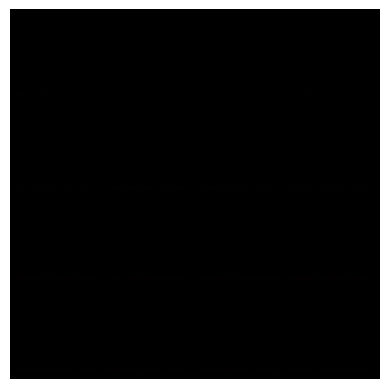

Epoch 1
Discriminator loss: 33.028237104415894
Generator loss: 9.901145905256271

Epoch 2
Discriminator loss: 31.52773356437683
Generator loss: 10.618063598871231

Epoch 3
Discriminator loss: 32.74790382385254
Generator loss: 10.356029599905014

Epoch 4
Discriminator loss: 34.45290493965149
Generator loss: 9.39705839753151

Epoch 5
Discriminator loss: 36.9819769859314
Generator loss: 8.929905250668526

Epoch 6
Discriminator loss: 39.1229829788208
Generator loss: 8.032768502831459

Epoch 7
Discriminator loss: 37.573797941207886
Generator loss: 8.58945220708847

Epoch 8
Discriminator loss: 37.067516922950745
Generator loss: 9.196726262569427

Epoch 9
Discriminator loss: 37.701016306877136
Generator loss: 9.162941455841064

Epoch 10
Discriminator loss: 38.29651319980621
Generator loss: 9.003566831350327

Epoch 11
Discriminator loss: 37.55438768863678
Generator loss: 9.000861003994942

Epoch 12
Discriminator loss: 38.265174984931946
Generator loss: 9.250706315040588

Epoch 13
Discriminator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06791158..0.051043823].


Epoch 100
Discriminator loss: 20.97569328546524
Generator loss: 22.139452278614044



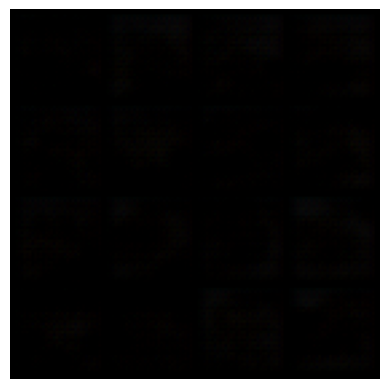

Epoch 101
Discriminator loss: 20.976901173591614
Generator loss: 21.673465728759766

Epoch 102
Discriminator loss: 21.09291398525238
Generator loss: 21.258286893367767

Epoch 103
Discriminator loss: 21.052413403987885
Generator loss: 21.489892184734344

Epoch 104
Discriminator loss: 20.888071656227112
Generator loss: 21.841475665569305

Epoch 105
Discriminator loss: 20.77782690525055
Generator loss: 21.930406272411346

Epoch 106
Discriminator loss: 21.075338900089264
Generator loss: 21.619976103305817

Epoch 107
Discriminator loss: 21.347119390964508
Generator loss: 21.54781800508499

Epoch 108
Discriminator loss: 21.88182783126831
Generator loss: 21.07586407661438

Epoch 109
Discriminator loss: 22.45706170797348
Generator loss: 20.108920753002167

Epoch 110
Discriminator loss: 22.09898555278778
Generator loss: 20.69369912147522

Epoch 111
Discriminator loss: 21.47884827852249
Generator loss: 22.55014044046402

Epoch 112
Discriminator loss: 21.31492567062378
Generator loss: 22.47434353

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11803383..0.10705913].


Epoch 200
Discriminator loss: 21.767699480056763
Generator loss: 22.255775332450867



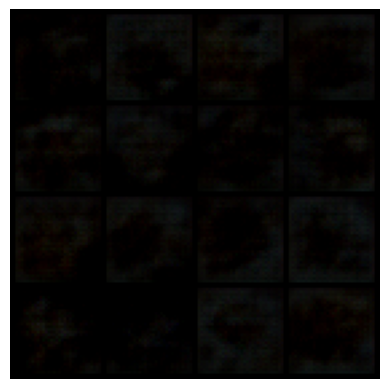

Epoch 201
Discriminator loss: 21.87125653028488
Generator loss: 21.51146125793457

Epoch 202
Discriminator loss: 22.032764077186584
Generator loss: 20.729036509990692

Epoch 203
Discriminator loss: 22.074747562408447
Generator loss: 20.814565360546112

Epoch 204
Discriminator loss: 21.989050269126892
Generator loss: 20.778859555721283

Epoch 205
Discriminator loss: 21.97130161523819
Generator loss: 20.796351611614227

Epoch 206
Discriminator loss: 21.904355823993683
Generator loss: 20.760163068771362

Epoch 207
Discriminator loss: 21.9624063372612
Generator loss: 21.367571532726288

Epoch 208
Discriminator loss: 22.019373178482056
Generator loss: 21.440751791000366

Epoch 209
Discriminator loss: 22.127610087394714
Generator loss: 21.35489523410797

Epoch 210
Discriminator loss: 22.08035010099411
Generator loss: 21.274497747421265

Epoch 211
Discriminator loss: 21.923959970474243
Generator loss: 21.593652725219727

Epoch 212
Discriminator loss: 21.96444135904312
Generator loss: 21.45732

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16737074..0.15505032].


Epoch 300
Discriminator loss: 21.619349360466003
Generator loss: 21.105317652225494



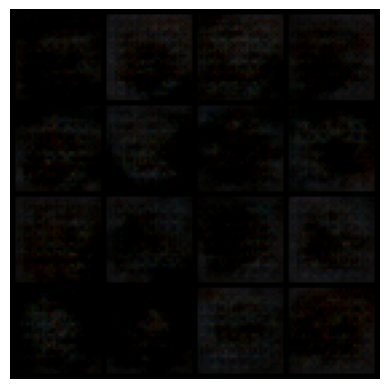

Epoch 301
Discriminator loss: 21.57838773727417
Generator loss: 21.407177329063416

Epoch 302
Discriminator loss: 21.543083906173706
Generator loss: 21.885671019554138

Epoch 303
Discriminator loss: 21.457104861736298
Generator loss: 21.72003400325775

Epoch 304
Discriminator loss: 21.583729565143585
Generator loss: 21.513856947422028

Epoch 305
Discriminator loss: 21.683007776737213
Generator loss: 21.33344691991806

Epoch 306
Discriminator loss: 21.646581530570984
Generator loss: 21.80498969554901

Epoch 307
Discriminator loss: 21.619559466838837
Generator loss: 21.34374290704727

Epoch 308
Discriminator loss: 21.632835268974304
Generator loss: 21.270809650421143

Epoch 309
Discriminator loss: 21.664996027946472
Generator loss: 21.633223116397858

Epoch 310
Discriminator loss: 21.566105842590332
Generator loss: 21.558926045894623

Epoch 311
Discriminator loss: 21.577855348587036
Generator loss: 21.128937244415283

Epoch 312
Discriminator loss: 21.580020129680634
Generator loss: 21.31

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18490574..0.19176994].


Epoch 400
Discriminator loss: 21.571202397346497
Generator loss: 21.182068467140198



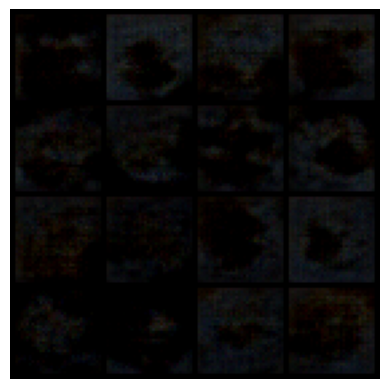

Epoch 401
Discriminator loss: 21.603096306324005
Generator loss: 21.66163468360901

Epoch 402
Discriminator loss: 21.484596252441406
Generator loss: 21.930267095565796

Epoch 403
Discriminator loss: 21.527387261390686
Generator loss: 21.479540526866913

Epoch 404
Discriminator loss: 21.55175429582596
Generator loss: 21.58269441127777

Epoch 405
Discriminator loss: 21.57943105697632
Generator loss: 21.47951167821884

Epoch 406
Discriminator loss: 21.635742664337158
Generator loss: 21.232049226760864

Epoch 407
Discriminator loss: 21.68066430091858
Generator loss: 21.14744758605957

Epoch 408
Discriminator loss: 21.480845510959625
Generator loss: 21.31997162103653

Epoch 409
Discriminator loss: 21.539203345775604
Generator loss: 21.60984194278717

Epoch 410
Discriminator loss: 21.642740786075592
Generator loss: 21.71294730901718

Epoch 411
Discriminator loss: 21.519246220588684
Generator loss: 21.80590456724167

Epoch 412
Discriminator loss: 21.5293989777565
Generator loss: 22.0020684599

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1973353..0.2413683].


Epoch 500
Discriminator loss: 21.581320881843567
Generator loss: 21.337948501110077



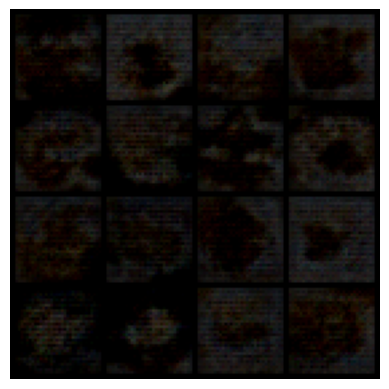

Epoch 501
Discriminator loss: 21.571552217006683
Generator loss: 21.537961959838867

Epoch 502
Discriminator loss: 21.545067727565765
Generator loss: 21.502151310443878

Epoch 503
Discriminator loss: 21.440908432006836
Generator loss: 21.56578665971756

Epoch 504
Discriminator loss: 21.497641921043396
Generator loss: 21.35532855987549

Epoch 505
Discriminator loss: 21.449222803115845
Generator loss: 21.707341611385345

Epoch 506
Discriminator loss: 21.545528054237366
Generator loss: 21.425888419151306

Epoch 507
Discriminator loss: 21.58262062072754
Generator loss: 21.423245310783386

Epoch 508
Discriminator loss: 21.56215661764145
Generator loss: 21.648716688156128

Epoch 509
Discriminator loss: 21.510803997516632
Generator loss: 21.303748428821564

Epoch 510
Discriminator loss: 21.452920019626617
Generator loss: 21.441710710525513

Epoch 511
Discriminator loss: 21.426482915878296
Generator loss: 21.980745792388916

Epoch 512
Discriminator loss: 21.477977395057678
Generator loss: 21.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22824436..0.26219413].


Epoch 600
Discriminator loss: 21.465138971805573
Generator loss: 21.42483699321747



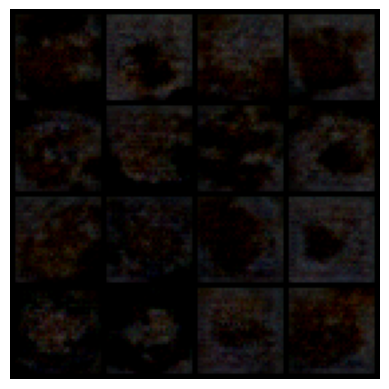

Epoch 601
Discriminator loss: 21.405477941036224
Generator loss: 21.55888795852661

Epoch 602
Discriminator loss: 21.484674036502838
Generator loss: 21.48899680376053

Epoch 603
Discriminator loss: 21.428315222263336
Generator loss: 21.41063928604126

Epoch 604
Discriminator loss: 21.42621946334839
Generator loss: 21.670359194278717

Epoch 605
Discriminator loss: 21.381485760211945
Generator loss: 21.625206410884857

Epoch 606
Discriminator loss: 21.499004542827606
Generator loss: 21.482282161712646

Epoch 607
Discriminator loss: 21.468786895275116
Generator loss: 21.406800031661987

Epoch 608
Discriminator loss: 21.446778774261475
Generator loss: 21.66310942173004

Epoch 609
Discriminator loss: 21.408394515514374
Generator loss: 21.788228452205658

Epoch 610
Discriminator loss: 21.405419051647186
Generator loss: 21.75910234451294

Epoch 611
Discriminator loss: 21.50200468301773
Generator loss: 21.55467176437378

Epoch 612
Discriminator loss: 21.466451346874237
Generator loss: 21.65849

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2916691..0.30746672].


Epoch 700
Discriminator loss: 21.380067765712738
Generator loss: 21.815219461917877



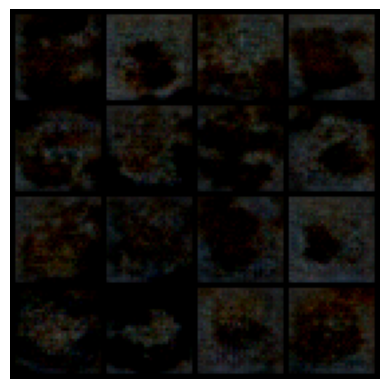

Epoch 701
Discriminator loss: 21.31268221139908
Generator loss: 21.90989077091217

Epoch 702
Discriminator loss: 21.3228742480278
Generator loss: 21.81317776441574

Epoch 703
Discriminator loss: 21.304785013198853
Generator loss: 21.59172248840332

Epoch 704
Discriminator loss: 21.38869082927704
Generator loss: 21.730745553970337

Epoch 705
Discriminator loss: 21.423615097999573
Generator loss: 21.72566419839859

Epoch 706
Discriminator loss: 21.33733379840851
Generator loss: 21.75034075975418

Epoch 707
Discriminator loss: 21.341010630130768
Generator loss: 21.456773936748505

Epoch 708
Discriminator loss: 21.345680475234985
Generator loss: 21.9454904794693

Epoch 709
Discriminator loss: 21.330489337444305
Generator loss: 21.569894671440125

Epoch 710
Discriminator loss: 21.24614781141281
Generator loss: 21.634525895118713

Epoch 711
Discriminator loss: 21.338403344154358
Generator loss: 21.57798582315445

Epoch 712
Discriminator loss: 21.343218088150024
Generator loss: 21.72860103845

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34844896..0.33542505].


Epoch 800
Discriminator loss: 21.247032701969147
Generator loss: 21.89956045150757



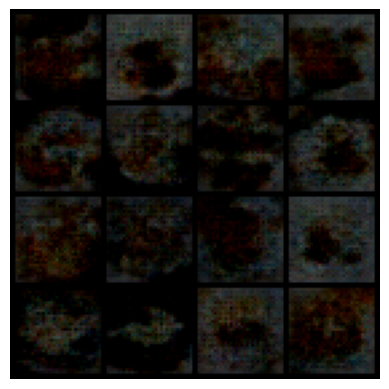

Epoch 801
Discriminator loss: 21.276362717151642
Generator loss: 21.752925276756287

Epoch 802
Discriminator loss: 21.185019195079803
Generator loss: 21.890563368797302

Epoch 803
Discriminator loss: 21.255393624305725
Generator loss: 21.358038187026978

Epoch 804
Discriminator loss: 21.230722725391388
Generator loss: 21.827047049999237

Epoch 805
Discriminator loss: 21.236994802951813
Generator loss: 21.9719455242157

Epoch 806
Discriminator loss: 21.180262804031372
Generator loss: 22.0338414311409

Epoch 807
Discriminator loss: 21.183456003665924
Generator loss: 21.94718462228775

Epoch 808
Discriminator loss: 21.248505473136902
Generator loss: 21.549845814704895

Epoch 809
Discriminator loss: 21.19875007867813
Generator loss: 21.833640038967133

Epoch 810
Discriminator loss: 21.228808760643005
Generator loss: 21.569415986537933

Epoch 811
Discriminator loss: 21.1819925904274
Generator loss: 21.97079885005951

Epoch 812
Discriminator loss: 21.191706597805023
Generator loss: 21.972906

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40575603..0.39883828].


Epoch 900
Discriminator loss: 21.101107478141785
Generator loss: 22.073790192604065



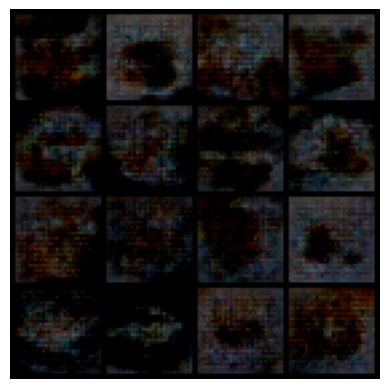

Epoch 901
Discriminator loss: 21.122115194797516
Generator loss: 22.194295585155487

Epoch 902
Discriminator loss: 21.078874945640564
Generator loss: 22.294956386089325

Epoch 903
Discriminator loss: 21.10060691833496
Generator loss: 21.991142868995667

Epoch 904
Discriminator loss: 21.106683373451233
Generator loss: 22.14696055650711

Epoch 905
Discriminator loss: 21.06556785106659
Generator loss: 22.189391493797302

Epoch 906
Discriminator loss: 21.14492130279541
Generator loss: 22.230703949928284

Epoch 907
Discriminator loss: 21.106212854385376
Generator loss: 22.028167247772217

Epoch 908
Discriminator loss: 21.134574949741364
Generator loss: 21.48967283964157

Epoch 909
Discriminator loss: 21.05701994895935
Generator loss: 21.934391260147095

Epoch 910
Discriminator loss: 21.08582043647766
Generator loss: 22.149032294750214

Epoch 911
Discriminator loss: 21.05351185798645
Generator loss: 21.92407113313675

Epoch 912
Discriminator loss: 21.09080010652542
Generator loss: 21.6232640

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3822359..0.42986017].


Epoch 1000
Discriminator loss: 20.999005377292633
Generator loss: 22.305623531341553



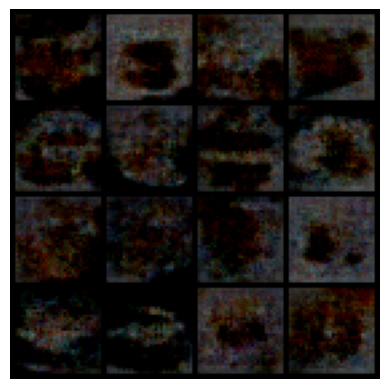

Epoch 1001
Discriminator loss: 20.95082801580429
Generator loss: 22.051437616348267

Epoch 1002
Discriminator loss: 20.96423852443695
Generator loss: 22.153501629829407

Epoch 1003
Discriminator loss: 21.023736476898193
Generator loss: 21.943516492843628

Epoch 1004
Discriminator loss: 21.002160012722015
Generator loss: 21.717515289783478

Epoch 1005
Discriminator loss: 21.005167067050934
Generator loss: 21.983777165412903

Epoch 1006
Discriminator loss: 20.976914405822754
Generator loss: 22.489075362682343

Epoch 1007
Discriminator loss: 20.928143978118896
Generator loss: 22.485377073287964

Epoch 1008
Discriminator loss: 20.98056983947754
Generator loss: 21.929479777812958

Epoch 1009
Discriminator loss: 20.948110699653625
Generator loss: 22.18985164165497

Epoch 1010
Discriminator loss: 20.98857480287552
Generator loss: 22.043373346328735

Epoch 1011
Discriminator loss: 20.939685106277466
Generator loss: 21.848415315151215

Epoch 1012
Discriminator loss: 20.86750054359436
Generator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46903467..0.492581].


Epoch 1100
Discriminator loss: 20.819817066192627
Generator loss: 22.319388508796692



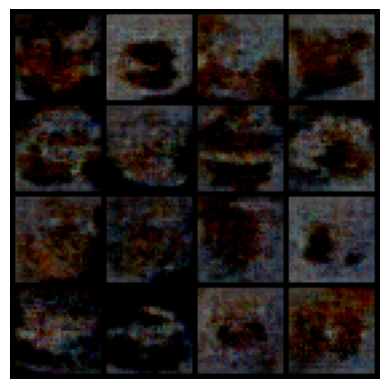

Epoch 1101
Discriminator loss: 20.75809156894684
Generator loss: 22.39383155107498

Epoch 1102
Discriminator loss: 20.818344116210938
Generator loss: 22.286666095256805

Epoch 1103
Discriminator loss: 20.816465258598328
Generator loss: 21.909084975719452

Epoch 1104
Discriminator loss: 20.72139835357666
Generator loss: 22.490539371967316

Epoch 1105
Discriminator loss: 20.872546672821045
Generator loss: 22.180997669696808

Epoch 1106
Discriminator loss: 20.828473508358
Generator loss: 22.268424332141876

Epoch 1107
Discriminator loss: 20.8066948056221
Generator loss: 22.468981504440308

Epoch 1108
Discriminator loss: 20.8475381731987
Generator loss: 22.564286530017853

Epoch 1109
Discriminator loss: 20.790573120117188
Generator loss: 22.410873532295227

Epoch 1110
Discriminator loss: 20.769178092479706
Generator loss: 21.815377593040466

Epoch 1111
Discriminator loss: 20.852233707904816
Generator loss: 21.9648380279541

Epoch 1112
Discriminator loss: 20.722454488277435
Generator loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5377126..0.5506674].


Epoch 1200
Discriminator loss: 20.579371988773346
Generator loss: 22.636493146419525



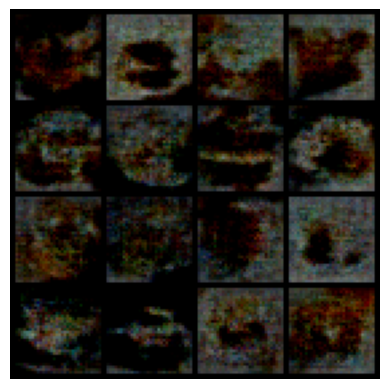

Epoch 1201
Discriminator loss: 20.626196324825287
Generator loss: 22.490185499191284

Epoch 1202
Discriminator loss: 20.5766322016716
Generator loss: 22.1391544342041

Epoch 1203
Discriminator loss: 20.52021896839142
Generator loss: 22.41483622789383

Epoch 1204
Discriminator loss: 20.613829970359802
Generator loss: 22.508645832538605

Epoch 1205
Discriminator loss: 20.645910322666168
Generator loss: 22.594248175621033

Epoch 1206
Discriminator loss: 20.59375488758087
Generator loss: 22.55218267440796

Epoch 1207
Discriminator loss: 20.607431828975677
Generator loss: 22.18792450428009

Epoch 1208
Discriminator loss: 20.670120418071747
Generator loss: 22.146718680858612

Epoch 1209
Discriminator loss: 20.524582266807556
Generator loss: 22.20463401079178

Epoch 1210
Discriminator loss: 20.5162136554718
Generator loss: 22.7446471452713

Epoch 1211
Discriminator loss: 20.53871250152588
Generator loss: 22.547939717769623

Epoch 1212
Discriminator loss: 20.537491858005524
Generator loss: 22.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53888255..0.60802984].


Epoch 1300
Discriminator loss: 20.36866396665573
Generator loss: 22.629661738872528



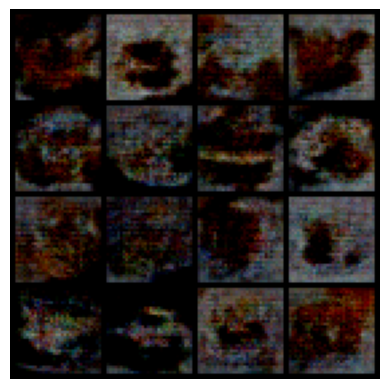

Epoch 1301
Discriminator loss: 20.34428173303604
Generator loss: 22.52597689628601

Epoch 1302
Discriminator loss: 20.315965950489044
Generator loss: 23.209076464176178

Epoch 1303
Discriminator loss: 20.346282243728638
Generator loss: 22.916425228118896

Epoch 1304
Discriminator loss: 20.40943032503128
Generator loss: 22.656701385974884

Epoch 1305
Discriminator loss: 20.332203686237335
Generator loss: 23.001619935035706

Epoch 1306
Discriminator loss: 20.34963345527649
Generator loss: 23.013646185398102

Epoch 1307
Discriminator loss: 20.395568311214447
Generator loss: 22.545477330684662

Epoch 1308
Discriminator loss: 20.304360926151276
Generator loss: 22.879568874835968

Epoch 1309
Discriminator loss: 20.372772991657257
Generator loss: 22.374866545200348

Epoch 1310
Discriminator loss: 20.35547113418579
Generator loss: 22.47688239812851

Epoch 1311
Discriminator loss: 20.267414271831512
Generator loss: 22.95443344116211

Epoch 1312
Discriminator loss: 20.28634488582611
Generator lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6544645..0.6506382].


Epoch 1400
Discriminator loss: 19.993605732917786
Generator loss: 23.222562849521637



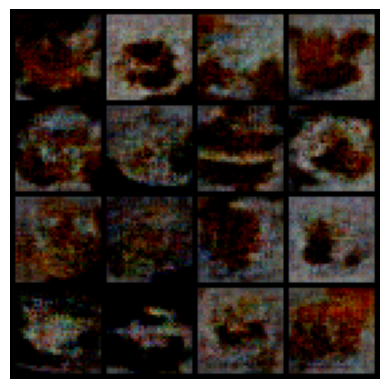

Epoch 1401
Discriminator loss: 19.954737722873688
Generator loss: 23.31078714132309

Epoch 1402
Discriminator loss: 19.96889728307724
Generator loss: 23.409026503562927

Epoch 1403
Discriminator loss: 20.016748130321503
Generator loss: 23.69168710708618

Epoch 1404
Discriminator loss: 20.083892226219177
Generator loss: 23.6297687292099

Epoch 1405
Discriminator loss: 20.020505845546722
Generator loss: 23.269580721855164

Epoch 1406
Discriminator loss: 19.984785199165344
Generator loss: 23.59982532262802

Epoch 1407
Discriminator loss: 20.075167775154114
Generator loss: 23.17092663049698

Epoch 1408
Discriminator loss: 19.985137104988098
Generator loss: 22.93280678987503

Epoch 1409
Discriminator loss: 19.982194781303406
Generator loss: 23.366088688373566

Epoch 1410
Discriminator loss: 20.01137524843216
Generator loss: 22.99063628911972

Epoch 1411
Discriminator loss: 20.02919864654541
Generator loss: 22.888124108314514

Epoch 1412
Discriminator loss: 19.971118450164795
Generator loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68333477..0.67331266].


Epoch 1500
Discriminator loss: 19.59136474132538
Generator loss: 23.132069528102875



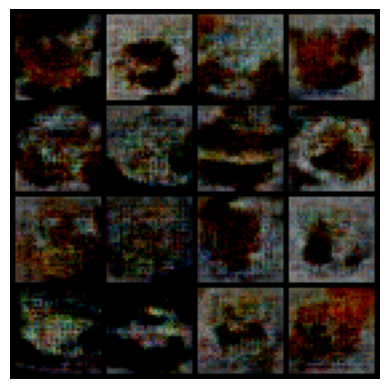

Epoch 1501
Discriminator loss: 19.625867247581482
Generator loss: 23.727937281131744

Epoch 1502
Discriminator loss: 19.652343273162842
Generator loss: 23.555082201957703

Epoch 1503
Discriminator loss: 19.637651681900024
Generator loss: 23.902483224868774

Epoch 1504
Discriminator loss: 19.555845499038696
Generator loss: 23.646945774555206

Epoch 1505
Discriminator loss: 19.65788370370865
Generator loss: 23.461469531059265

Epoch 1506
Discriminator loss: 19.60764443874359
Generator loss: 23.60592085123062

Epoch 1507
Discriminator loss: 19.58212000131607
Generator loss: 23.847431182861328

Epoch 1508
Discriminator loss: 19.6452277302742
Generator loss: 23.56129026412964

Epoch 1509
Discriminator loss: 19.591205418109894
Generator loss: 24.174219846725464

Epoch 1510
Discriminator loss: 19.57946354150772
Generator loss: 23.939050793647766

Epoch 1511
Discriminator loss: 19.513315081596375
Generator loss: 23.874224960803986

Epoch 1512
Discriminator loss: 19.64249473810196
Generator los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76944035..0.7140373].


Epoch 1600
Discriminator loss: 19.084279239177704
Generator loss: 23.874341249465942



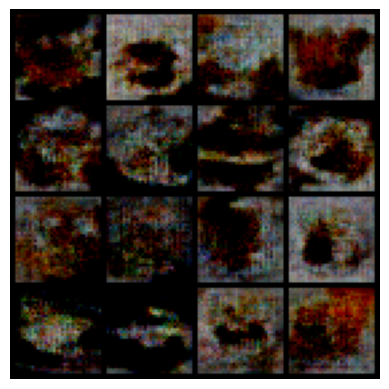

Epoch 1601
Discriminator loss: 19.19760435819626
Generator loss: 24.867419064044952

Epoch 1602
Discriminator loss: 19.185775458812714
Generator loss: 24.150043785572052

Epoch 1603
Discriminator loss: 19.096187353134155
Generator loss: 24.472502887248993

Epoch 1604
Discriminator loss: 19.130717992782593
Generator loss: 24.465265035629272

Epoch 1605
Discriminator loss: 19.228851854801178
Generator loss: 24.521880328655243

Epoch 1606
Discriminator loss: 19.20946741104126
Generator loss: 24.045535564422607

Epoch 1607
Discriminator loss: 19.09399574995041
Generator loss: 24.699529111385345

Epoch 1608
Discriminator loss: 19.058324992656708
Generator loss: 24.515855371952057

Epoch 1609
Discriminator loss: 19.108766973018646
Generator loss: 24.242350220680237

Epoch 1610
Discriminator loss: 19.147298097610474
Generator loss: 24.376487493515015

Epoch 1611
Discriminator loss: 19.0958251953125
Generator loss: 24.581320106983185

Epoch 1612
Discriminator loss: 19.00744140148163
Generator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7581153..0.7662377].


Epoch 1700
Discriminator loss: 18.5595463514328
Generator loss: 25.75026571750641



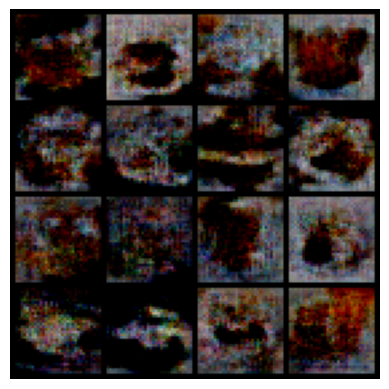

Epoch 1701
Discriminator loss: 18.622085869312286
Generator loss: 25.024282574653625

Epoch 1702
Discriminator loss: 18.45503067970276
Generator loss: 25.184583127498627

Epoch 1703
Discriminator loss: 18.663362681865692
Generator loss: 24.639632284641266

Epoch 1704
Discriminator loss: 18.415614783763885
Generator loss: 25.17240709066391

Epoch 1705
Discriminator loss: 18.520229637622833
Generator loss: 24.933216333389282

Epoch 1706
Discriminator loss: 18.58175164461136
Generator loss: 25.321008443832397

Epoch 1707
Discriminator loss: 18.446771144866943
Generator loss: 25.17204225063324

Epoch 1708
Discriminator loss: 18.48264491558075
Generator loss: 26.023406624794006

Epoch 1709
Discriminator loss: 18.648564219474792
Generator loss: 24.992468059062958

Epoch 1710
Discriminator loss: 18.461334466934204
Generator loss: 25.31734138727188

Epoch 1711
Discriminator loss: 18.609211266040802
Generator loss: 25.037842869758606

Epoch 1712
Discriminator loss: 18.382698833942413
Generator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82435966..0.78972185].


Epoch 1800
Discriminator loss: 17.963603377342224
Generator loss: 25.979253888130188



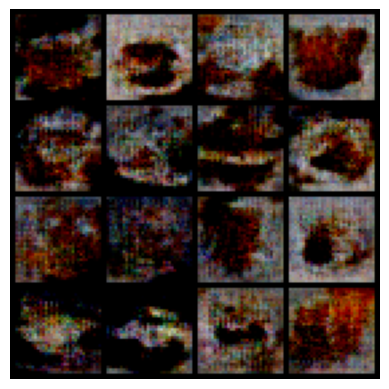

Epoch 1801
Discriminator loss: 17.796338856220245
Generator loss: 25.18179053068161

Epoch 1802
Discriminator loss: 17.793679118156433
Generator loss: 25.908229887485504

Epoch 1803
Discriminator loss: 18.158907890319824
Generator loss: 26.2161123752594

Epoch 1804
Discriminator loss: 17.84997844696045
Generator loss: 26.094141900539398

Epoch 1805
Discriminator loss: 17.995796620845795
Generator loss: 26.38582682609558

Epoch 1806
Discriminator loss: 17.827236354351044
Generator loss: 26.412894368171692

Epoch 1807
Discriminator loss: 17.844159364700317
Generator loss: 26.369832277297974

Epoch 1808
Discriminator loss: 18.131381332874298
Generator loss: 26.413233399391174

Epoch 1809
Discriminator loss: 17.82683891057968
Generator loss: 26.11940437555313

Epoch 1810
Discriminator loss: 18.012043178081512
Generator loss: 26.75375247001648

Epoch 1811
Discriminator loss: 17.72300899028778
Generator loss: 26.438654720783234

Epoch 1812
Discriminator loss: 17.988673269748688
Generator los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86460084..0.83679926].


Epoch 1900
Discriminator loss: 17.18213927745819
Generator loss: 28.05296903848648



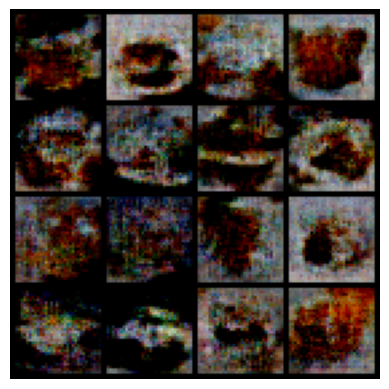

Epoch 1901
Discriminator loss: 17.072748720645905
Generator loss: 27.106710076332092

Epoch 1902
Discriminator loss: 17.358842968940735
Generator loss: 26.942655444145203

Epoch 1903
Discriminator loss: 17.106303334236145
Generator loss: 27.757446467876434

Epoch 1904
Discriminator loss: 17.1535422205925
Generator loss: 27.90309864282608

Epoch 1905
Discriminator loss: 17.089086174964905
Generator loss: 27.218372106552124

Epoch 1906
Discriminator loss: 17.29511272907257
Generator loss: 27.190871357917786

Epoch 1907
Discriminator loss: 17.276187896728516
Generator loss: 27.168538689613342

Epoch 1908
Discriminator loss: 17.082610368728638
Generator loss: 28.07956075668335

Epoch 1909
Discriminator loss: 17.048885583877563
Generator loss: 27.84218019247055

Epoch 1910
Discriminator loss: 17.249744653701782
Generator loss: 27.898069262504578

Epoch 1911
Discriminator loss: 17.228288888931274
Generator loss: 27.75092649459839

Epoch 1912
Discriminator loss: 17.168098151683807
Generator l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.864017..0.8557645].


Epoch 2000
Discriminator loss: 16.30149608850479
Generator loss: 28.06217485666275



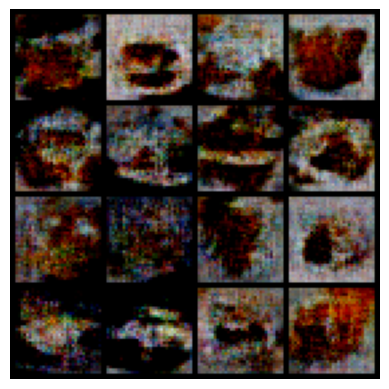

Epoch 2001
Discriminator loss: 16.357616364955902
Generator loss: 28.63678503036499

Epoch 2002
Discriminator loss: 16.33964142203331
Generator loss: 28.342221915721893

Epoch 2003
Discriminator loss: 16.450473099946976
Generator loss: 28.60271281003952

Epoch 2004
Discriminator loss: 16.38246187567711
Generator loss: 29.21007215976715

Epoch 2005
Discriminator loss: 16.19763332605362
Generator loss: 28.376426458358765

Epoch 2006
Discriminator loss: 16.457751125097275
Generator loss: 28.707091331481934

Epoch 2007
Discriminator loss: 16.51669704914093
Generator loss: 28.590466678142548

Epoch 2008
Discriminator loss: 16.330979466438293
Generator loss: 29.031390845775604

Epoch 2009
Discriminator loss: 16.23955261707306
Generator loss: 28.63427382707596

Epoch 2010
Discriminator loss: 16.326067090034485
Generator loss: 28.984163463115692

Epoch 2011
Discriminator loss: 16.36099323630333
Generator loss: 29.439055502414703

Epoch 2012
Discriminator loss: 16.33354750275612
Generator loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88387567..0.8326036].


Epoch 2100
Discriminator loss: 15.642497658729553
Generator loss: 30.654451429843903



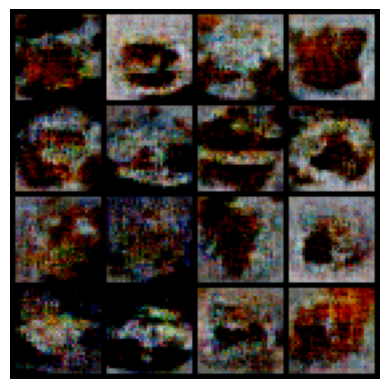

Epoch 2101
Discriminator loss: 15.649689137935638
Generator loss: 30.66174453496933

Epoch 2102
Discriminator loss: 15.45103731751442
Generator loss: 30.097394049167633

Epoch 2103
Discriminator loss: 15.677812248468399
Generator loss: 29.77690577507019

Epoch 2104
Discriminator loss: 15.629483699798584
Generator loss: 30.300621509552002

Epoch 2105
Discriminator loss: 15.614318370819092
Generator loss: 30.985447824001312

Epoch 2106
Discriminator loss: 15.61267676949501
Generator loss: 30.459079027175903

Epoch 2107
Discriminator loss: 15.374103277921677
Generator loss: 30.84017765522003

Epoch 2108
Discriminator loss: 15.647632658481598
Generator loss: 30.234532117843628

Epoch 2109
Discriminator loss: 15.436842262744904
Generator loss: 30.042790353298187

Epoch 2110
Discriminator loss: 15.461800426244736
Generator loss: 30.491819381713867

Epoch 2111
Discriminator loss: 15.683486342430115
Generator loss: 30.22042739391327

Epoch 2112
Discriminator loss: 15.572604805231094
Generator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.907194..0.84612906].


Epoch 2200
Discriminator loss: 14.794438987970352
Generator loss: 31.94618582725525



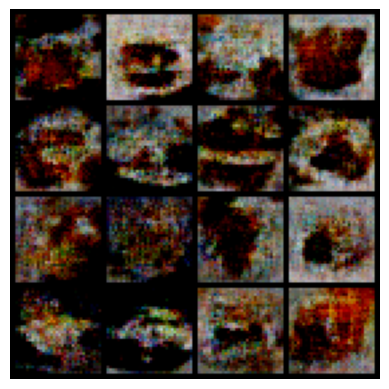

Epoch 2201
Discriminator loss: 14.773860573768616
Generator loss: 31.972204566001892

Epoch 2202
Discriminator loss: 14.918446153402328
Generator loss: 32.61773639917374

Epoch 2203
Discriminator loss: 14.538731127977371
Generator loss: 31.849517166614532

Epoch 2204
Discriminator loss: 14.615952402353287
Generator loss: 32.44630813598633

Epoch 2205
Discriminator loss: 14.893712937831879
Generator loss: 32.15298271179199

Epoch 2206
Discriminator loss: 14.888801991939545
Generator loss: 31.778080821037292

Epoch 2207
Discriminator loss: 14.904368132352829
Generator loss: 32.11615687608719

Epoch 2208
Discriminator loss: 14.653831958770752
Generator loss: 30.866827428340912

Epoch 2209
Discriminator loss: 14.678322583436966
Generator loss: 32.96936899423599

Epoch 2210
Discriminator loss: 14.871886879205704
Generator loss: 32.03699916601181

Epoch 2211
Discriminator loss: 14.904027968645096
Generator loss: 32.38908249139786

Epoch 2212
Discriminator loss: 14.958632290363312
Generator l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90425956..0.87488997].


Epoch 2300
Discriminator loss: 14.089218229055405
Generator loss: 33.2702779173851



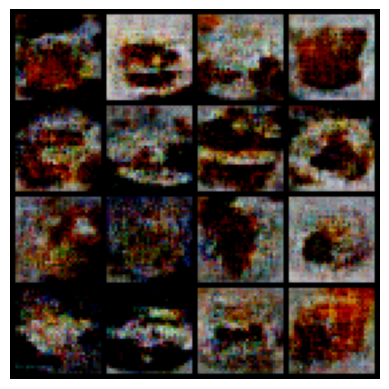

Epoch 2301
Discriminator loss: 14.087544530630112
Generator loss: 34.294265151023865

Epoch 2302
Discriminator loss: 13.937883079051971
Generator loss: 33.592784345149994

Epoch 2303
Discriminator loss: 13.792395234107971
Generator loss: 34.04479944705963

Epoch 2304
Discriminator loss: 14.055500566959381
Generator loss: 34.37999975681305

Epoch 2305
Discriminator loss: 14.040326207876205
Generator loss: 34.36685883998871

Epoch 2306
Discriminator loss: 13.8310107588768
Generator loss: 34.948838889598846

Epoch 2307
Discriminator loss: 13.821522682905197
Generator loss: 34.827219009399414

Epoch 2308
Discriminator loss: 13.943418800830841
Generator loss: 34.471553325653076

Epoch 2309
Discriminator loss: 14.007779777050018
Generator loss: 33.64152365922928

Epoch 2310
Discriminator loss: 14.126142889261246
Generator loss: 34.201228737831116

Epoch 2311
Discriminator loss: 13.845875412225723
Generator loss: 33.931294679641724

Epoch 2312
Discriminator loss: 13.887708276510239
Generator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8887722..0.901254].


Epoch 2400
Discriminator loss: 13.335125237703323
Generator loss: 36.19740319252014



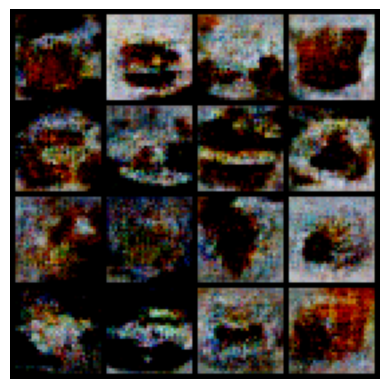

Epoch 2401
Discriminator loss: 13.03295636177063
Generator loss: 36.201871275901794

Epoch 2402
Discriminator loss: 13.274598807096481
Generator loss: 36.12237310409546

Epoch 2403
Discriminator loss: 13.082718402147293
Generator loss: 36.5661997795105

Epoch 2404
Discriminator loss: 13.067460715770721
Generator loss: 36.31056368350983

Epoch 2405
Discriminator loss: 13.115679144859314
Generator loss: 35.861148715019226

Epoch 2406
Discriminator loss: 13.31435975432396
Generator loss: 36.19072198867798

Epoch 2407
Discriminator loss: 13.183939278125763
Generator loss: 35.89743411540985

Epoch 2408
Discriminator loss: 13.202710896730423
Generator loss: 36.59629821777344

Epoch 2409
Discriminator loss: 12.930468916893005
Generator loss: 36.147111892700195

Epoch 2410
Discriminator loss: 13.254367738962173
Generator loss: 36.07985973358154

Epoch 2411
Discriminator loss: 13.12742206454277
Generator loss: 36.04764246940613

Epoch 2412
Discriminator loss: 13.08198207616806
Generator loss: 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88854563..0.92929345].


Epoch 2500
Discriminator loss: 12.667711108922958
Generator loss: 38.24819457530975



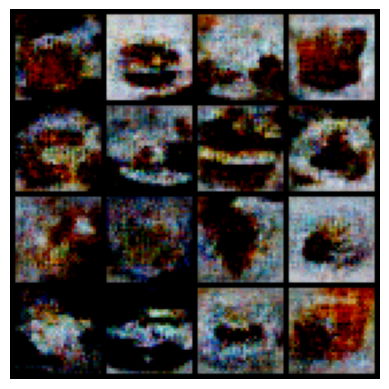

Epoch 2501
Discriminator loss: 12.561408072710037
Generator loss: 38.61796975135803

Epoch 2502
Discriminator loss: 12.610317587852478
Generator loss: 38.03379738330841

Epoch 2503
Discriminator loss: 12.467295408248901
Generator loss: 38.448882818222046

Epoch 2504
Discriminator loss: 12.347983598709106
Generator loss: 37.55407702922821

Epoch 2505
Discriminator loss: 12.29879629611969
Generator loss: 36.57282757759094

Epoch 2506
Discriminator loss: 12.36573413014412
Generator loss: 39.22988700866699

Epoch 2507
Discriminator loss: 11.90195819735527
Generator loss: 38.85253310203552

Epoch 2508
Discriminator loss: 12.376073181629181
Generator loss: 39.19591689109802

Epoch 2509
Discriminator loss: 12.60817375779152
Generator loss: 37.480905532836914

Epoch 2510
Discriminator loss: 12.361649751663208
Generator loss: 38.982755184173584

Epoch 2511
Discriminator loss: 12.383367478847504
Generator loss: 38.32127046585083

Epoch 2512
Discriminator loss: 12.276629716157913
Generator loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90033674..0.9283831].


Epoch 2600
Discriminator loss: 11.919248312711716
Generator loss: 40.37903189659119



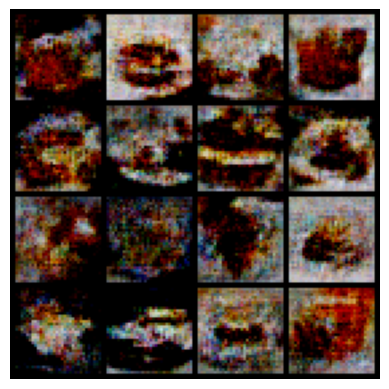

Epoch 2601
Discriminator loss: 11.754207789897919
Generator loss: 40.86647939682007

Epoch 2602
Discriminator loss: 11.486926823854446
Generator loss: 41.08147859573364

Epoch 2603
Discriminator loss: 11.587332129478455
Generator loss: 39.56433045864105

Epoch 2604
Discriminator loss: 11.764058738946915
Generator loss: 40.62210023403168

Epoch 2605
Discriminator loss: 11.755620658397675
Generator loss: 41.302995681762695

Epoch 2606
Discriminator loss: 11.925312250852585
Generator loss: 40.455822467803955

Epoch 2607
Discriminator loss: 11.70958960056305
Generator loss: 40.514880657196045

Epoch 2608
Discriminator loss: 11.611263871192932
Generator loss: 40.4911150932312

Epoch 2609
Discriminator loss: 11.645402640104294
Generator loss: 41.77086675167084

Epoch 2610
Discriminator loss: 11.667223751544952
Generator loss: 41.52177011966705

Epoch 2611
Discriminator loss: 11.759588897228241
Generator loss: 40.033154249191284

Epoch 2612
Discriminator loss: 11.408025115728378
Generator los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9000591..0.93781227].


Epoch 2700
Discriminator loss: 11.042699843645096
Generator loss: 43.12378108501434



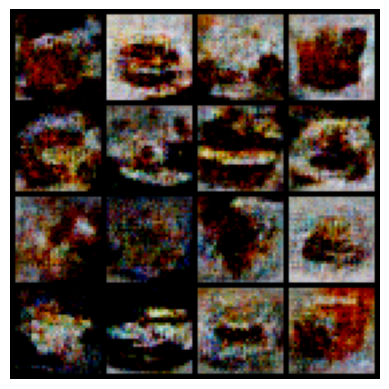

Epoch 2701
Discriminator loss: 11.081798374652863
Generator loss: 44.23990321159363

Epoch 2702
Discriminator loss: 10.962757974863052
Generator loss: 42.82945466041565

Epoch 2703
Discriminator loss: 10.950281709432602
Generator loss: 42.77096784114838

Epoch 2704
Discriminator loss: 11.42452186346054
Generator loss: 44.242427587509155

Epoch 2705
Discriminator loss: 11.086975067853928
Generator loss: 42.97453224658966

Epoch 2706
Discriminator loss: 11.144043743610382
Generator loss: 43.302589535713196

Epoch 2707
Discriminator loss: 10.914856135845184
Generator loss: 43.30017066001892

Epoch 2708
Discriminator loss: 10.997604876756668
Generator loss: 44.46229588985443

Epoch 2709
Discriminator loss: 10.97989022731781
Generator loss: 43.77560353279114

Epoch 2710
Discriminator loss: 11.390604823827744
Generator loss: 42.494728088378906

Epoch 2711
Discriminator loss: 11.233498275279999
Generator loss: 42.94833779335022

Epoch 2712
Discriminator loss: 11.087323099374771
Generator loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92830235..0.9366216].


Epoch 2800
Discriminator loss: 10.403907746076584
Generator loss: 47.056599855422974



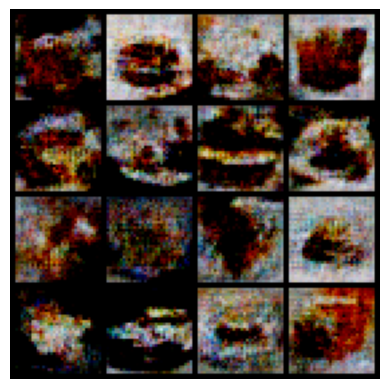

Epoch 2801
Discriminator loss: 10.481589764356613
Generator loss: 45.15460681915283

Epoch 2802
Discriminator loss: 10.236404299736023
Generator loss: 46.60666036605835

Epoch 2803
Discriminator loss: 10.599098920822144
Generator loss: 45.84446930885315

Epoch 2804
Discriminator loss: 10.532791435718536
Generator loss: 47.038997530937195

Epoch 2805
Discriminator loss: 10.261695086956024
Generator loss: 46.55115568637848

Epoch 2806
Discriminator loss: 10.523187220096588
Generator loss: 47.35783016681671

Epoch 2807
Discriminator loss: 10.328748971223831
Generator loss: 45.3972944021225

Epoch 2808
Discriminator loss: 10.44511666893959
Generator loss: 45.98551166057587

Epoch 2809
Discriminator loss: 10.427182525396347
Generator loss: 47.6285674571991

Epoch 2810
Discriminator loss: 10.350850254297256
Generator loss: 45.445117592811584

Epoch 2811
Discriminator loss: 10.32702225446701
Generator loss: 46.587483406066895

Epoch 2812
Discriminator loss: 10.50645923614502
Generator loss: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92011875..0.94861966].


Epoch 2900
Discriminator loss: 9.786538943648338
Generator loss: 50.45707559585571



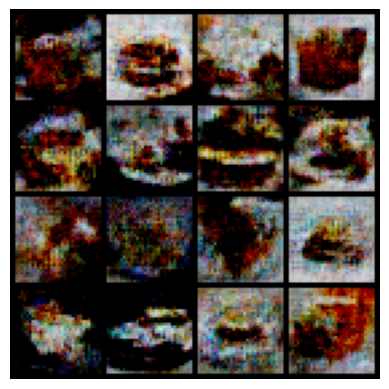

Epoch 2901
Discriminator loss: 9.788374036550522
Generator loss: 49.759692311286926

Epoch 2902
Discriminator loss: 9.868883937597275
Generator loss: 47.84025716781616

Epoch 2903
Discriminator loss: 9.838151067495346
Generator loss: 49.16017544269562

Epoch 2904
Discriminator loss: 9.635312125086784
Generator loss: 49.19191062450409

Epoch 2905
Discriminator loss: 10.023092448711395
Generator loss: 48.42914605140686

Epoch 2906
Discriminator loss: 9.808103322982788
Generator loss: 49.15137219429016

Epoch 2907
Discriminator loss: 9.525267332792282
Generator loss: 48.6275475025177

Epoch 2908
Discriminator loss: 9.774931371212006
Generator loss: 49.47256147861481

Epoch 2909
Discriminator loss: 9.591679394245148
Generator loss: 49.51851236820221

Epoch 2910
Discriminator loss: 9.772548526525497
Generator loss: 50.667500138282776

Epoch 2911
Discriminator loss: 9.760731935501099
Generator loss: 49.24188470840454

Epoch 2912
Discriminator loss: 9.836225837469101
Generator loss: 49.507997

In [39]:
discriminator_loss = []
generator_loss = []

number_of_epochs = 3000

for i in range(number_of_epochs):
    dis_running_loss = 0.0
    gen_running_loss = 0.0

    for batch in data_loader:

        dis_optim.zero_grad()

        labels_1 = (torch.zeros(len(batch)) + 1.0).to(device)
        pred_labels = discriminator(batch)
        loss_dis1 = criterion(pred_labels, labels_1.reshape(-1, 1))


        with torch.no_grad():
            random_batch = generator.generate_random_batch(batch_size, device)
        
        labels_0 = torch.zeros(batch_size).to(device)
        pred_labels = discriminator(random_batch)
        loss_dis2 = criterion(pred_labels, labels_0.reshape(-1, 1))

        loss_dis = (loss_dis1 + loss_dis2) / 2
        loss_dis.backward()
        dis_optim.step()
        dis_running_loss += loss_dis.item()
        
        # Generator step

        gen_optim.zero_grad()

        random_batch = generator.generate_random_batch(batch_size*2, device)
        labels = (torch.zeros(batch_size*2) + 1.0).to(device)
        pred_labels = discriminator(random_batch)
        loss_gen = criterion(pred_labels, labels.reshape(-1, 1))
        loss_gen.backward()
        gen_optim.step()

        gen_running_loss += loss_gen.item()

        # total += len(batch)
        # good += ((sigmoid(pred_labels) > 0.5) == (labels_1 > 0.5).reshape(-1, 1)).sum()

    
    print(f"Epoch {i}")
    print(f"Discriminator loss: {dis_running_loss}")
    print(f"Generator loss: {gen_running_loss}")
    # print(f"{good / total}")
    print()
    
    if i % 100 == 0:
        plot_test_vectors()

In [5]:
rand_vec = torch.randn(16, 64).to(device)
out = generator(rand_vec)

NameError: name 'device' is not defined